# **Importing all the necessary libraries**

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
import numpy as np
import pandas as pd

## **Encoder class**

In [5]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, rnn_cell='lstm', dropout=0.5, bidirectional=True):
        super(Encoder, self).__init__()  # Initialize the Encoder class.
        self.embedding = nn.Embedding(num_embeddings=input_size, embedding_dim=embedding_size)  # Define an embedding layer.
        self.dropout = nn.Dropout(dropout)  # Apply dropout regularization.
        self.hidden_size = hidden_size  # Set the hidden size.
        self.num_layers = num_layers  # Set the number of layers.
        self.bidirectional = bidirectional  # Specify if the RNN is bidirectional.
        
        rnn_hidden_size = hidden_size // 2 if bidirectional else hidden_size  # Calculate the hidden size of each direction.

        # Choose the appropriate RNN cell based on the input.
        if rnn_cell.lower() == 'lstm':
            self.rnn = nn.LSTM(embedding_size, rnn_hidden_size, num_layers, batch_first=True, dropout=(0 if num_layers == 1 else dropout), bidirectional=bidirectional)
        elif rnn_cell.lower() == 'gru':
            self.rnn = nn.GRU(embedding_size, rnn_hidden_size, num_layers, batch_first=True, dropout=(0 if num_layers == 1 else dropout), bidirectional=bidirectional)
        else:
            self.rnn = nn.RNN(embedding_size, rnn_hidden_size, num_layers, batch_first=True, dropout=(0 if num_layers == 1 else dropout), bidirectional=bidirectional)
    
    def forward(self, x):
        embedded = self.embedding(x)  # Embed the input.
        embedded = self.dropout(embedded)  # Apply dropout to the embedded input.
        outputs, hidden = self.rnn(embedded)  # Pass the embedded input through the RNN.

        if self.bidirectional:  # If bidirectional, concatenate hidden states appropriately.
            if isinstance(hidden, tuple):  # If LSTM, concatenate both hidden and cell states.
                h_n, c_n = hidden
#                 print('enc h bef dir',h_n.shape)
#                 print('enc c bef dir',c_n.shape)
                h_n = torch.cat((h_n[0::2], h_n[1::2]), dim=2)  # Concatenate hidden states.
                c_n = torch.cat((c_n[0::2], c_n[1::2]), dim=2)  # Concatenate cell states.
#                 print('enc h af dir',h_n.shape)
#                 print('enc c af dir',c_n.shape)
                hidden = (h_n, c_n)  # Update hidden states.
            else:  # If GRU or RNN, concatenate hidden states only.
#                 print('enc hidd bef dir',hidden.shape)
                hidden = torch.cat((hidden[0::2], hidden[1::2]), dim=2)  # Concatenate hidden states.
#                 print('after dir enc:',hidden.shape)

        return outputs, hidden  # Return RNN outputs and hidden states.


## **Attention Module**

In [6]:
class Attention(nn.Module):
    def __init__(self, hidden_size, rnn_cell):
        super(Attention, self).__init__()  # Initialize the Attention class.
        self.attn = nn.Linear(hidden_size * 2, hidden_size)  # Define a linear layer for attention calculation.
        self.v = nn.Parameter(torch.rand(hidden_size))  # Define a learnable parameter v.
        self.rnn_cell = rnn_cell  # Store the type of RNN cell used.

    def forward(self, hidden, encoder_outputs):
        timestep = encoder_outputs.size(1)  # Get the number of timesteps.
#         print(hidden.shape) 
        if self.rnn_cell == 'lstm':
            hidden = hidden[-1]  # Extract the last hidden state if LSTM.
        else:
            hidden = hidden  # Keep the hidden state if not LSTM.
        h = hidden.unsqueeze(1).repeat(1, timestep, 1)  # Repeat hidden state for each timestep.
#         print('h',h.shape)
        encoder_outputs = encoder_outputs.permute(0, 1, 2)  # Change encoder_outputs shape.
#         print('encoder_outputs',encoder_outputs.shape)
        attn_energies = self.score(h, encoder_outputs)  # Calculate attention energies.
#         print('attn_energies',attn_energies.shape) 
        return F.softmax(attn_energies, dim=1).unsqueeze(1)  # Apply softmax and return attention weights.

    def score(self, hidden, encoder_outputs):
#         print('hidden',hidden.shape) 
#         print('encoder_outputs',encoder_outputs.shape)
        energy = torch.tanh(self.attn(torch.cat([hidden, encoder_outputs], 2)))  # Calculate attention energy.
#         print('energy',energy.shape)
        energy = energy.permute(0, 2, 1)  # Change energy shape.
#         print('energy',energy.shape)
        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(1)  # Repeat v for batch size.
#         print('v',v.shape)
        energy = torch.bmm(v, energy)  # Calculate energy.
#         print('energy',energy.shape)
        return energy.squeeze(1)  # Return squeezed energy.


## **Decoder class**

In [7]:
class Decoder(nn.Module):
    def __init__(self, output_size, embedding_size, hidden_size, num_layers, encoder_num_layers, attention, rnn_cell='lstm', dropout=0.5, bidirectional=True):
        super(Decoder, self).__init__()  # Initialize the Decoder class.
        self.embedding = nn.Embedding(num_embeddings=output_size, embedding_dim=embedding_size)  # Define an embedding layer.
        self.dropout = nn.Dropout(dropout)  # Apply dropout regularization.
        self.output_size = output_size  # Set the output size.
        self.hidden_size = hidden_size * encoder_num_layers if bidirectional else hidden_size  # Adjust hidden size based on bidirectionality.
        self.num_layers = num_layers  # Set the number of layers.
        self.attention = attention  # Store the attention mechanism.
        
        # Choose the appropriate RNN cell based on the input.
        if rnn_cell.lower() == 'lstm':
            self.rnn = nn.LSTM(embedding_size + hidden_size * encoder_num_layers, self.hidden_size, num_layers, batch_first=True, dropout=(0 if num_layers == 1 else dropout))
        elif rnn_cell.lower() == 'gru':
            self.rnn = nn.GRU(embedding_size + hidden_size * encoder_num_layers, self.hidden_size, num_layers, batch_first=True, dropout=(0 if num_layers == 1 else dropout))
        else:
            self.rnn = nn.RNN(embedding_size + hidden_size * encoder_num_layers, self.hidden_size, num_layers, batch_first=True, dropout=(0 if num_layers == 1 else dropout))
        
        self.fc = nn.Linear(self.hidden_size, output_size)  # Define a fully connected layer for the output.
        
    def forward(self, x, hidden, encoder_outputs):
        x = x.unsqueeze(1)  # Add a dimension for the batch size.
        embedded = self.dropout(self.embedding(x))  # Embed the input and apply dropout.
        
        attn_weights = self.attention(hidden[-1], encoder_outputs)  # Calculate attention weights.
        context = attn_weights.bmm(encoder_outputs)  # Compute the context vector.
        rnn_input = torch.cat((embedded, context), 2)  # Concatenate the embedded input and context vector.
        
        output, hidden = self.rnn(rnn_input, hidden)  # Pass the concatenated input through the RNN.
        output = self.fc(self.dropout(output.squeeze(1)))  # Apply dropout, squeeze the output, and pass it through the fully connected layer.
        
        return output, hidden, attn_weights  # Return the output, hidden state, and attention weights.


## **Sequence to Sequence model for the above encoder and decoder**

In [8]:
class Seq_to_Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq_to_Seq, self).__init__()  # Initialize the Seq_to_Seq class.
        self.encoder = encoder  # Set the encoder.
        self.decoder = decoder  # Set the decoder.

    def forward(self, source, target, teaching_force_ratio=0.5):
        batch_size = source.size(0)  # Get the batch size.
        target_len = target.size(1)  # Get the length of the target sequence.
        target_vocab_size = self.decoder.output_size  # Get the size of the target vocabulary.
        outputs = torch.zeros(batch_size, target_len, target_vocab_size).to(source.device)  # Initialize the output tensor.
        attention_weights = []  # List to store attention weights.
        encoder_outputs, encoder_hidden = self.encoder(source)  # Pass the source through the encoder.
        
        if isinstance(encoder_hidden, tuple):  # If the encoder uses LSTM, handle the hidden and cell states.
            h_n, c_n = encoder_hidden
            if self.encoder.bidirectional:  # If the encoder is bidirectional, concatenate the hidden states.
                h_n = torch.cat([h_n[i:i+1] for i in range(0, h_n.shape[0], 2)] + [h_n[i:i+1] for i in range(1, h_n.shape[0], 2)], dim=2)
                c_n = torch.cat([c_n[i:i+1] for i in range(0, c_n.shape[0], 2)] + [c_n[i:i+1] for i in range(1, c_n.shape[0], 2)], dim=2)
            
            if h_n.size(0) < self.decoder.num_layers:  # Adjust hidden and cell states to match the decoder layers.
                zero_h = torch.zeros(self.decoder.num_layers - h_n.size(0), batch_size, self.encoder.num_layers * self.encoder.hidden_size, device=h_n.device)
                zero_c = torch.zeros(self.decoder.num_layers - c_n.size(0), batch_size, self.encoder.num_layers * self.encoder.hidden_size, device=c_n.device)
                h_n = torch.cat([h_n, zero_h], dim=0)
                c_n = torch.cat([c_n, zero_c], dim=0)

            encoder_hidden = (h_n[:self.decoder.num_layers], c_n[:self.decoder.num_layers])  # Set encoder hidden state for decoder.
        else:
            h_n = encoder_hidden  # If the encoder uses GRU or RNN, handle the hidden state.
            if self.encoder.bidirectional:  # If the encoder is bidirectional, concatenate the hidden states.
                h_n = torch.cat([h_n[i:i+1] for i in range(0, h_n.shape[0], 2)] + [h_n[i:i+1] for i in range(1, h_n.shape[0], 2)], dim=2)
            
            if h_n.size(0) < self.decoder.num_layers:  # Adjust hidden state to match the decoder layers.
                zero_h = torch.zeros(self.decoder.num_layers - h_n.size(0), batch_size, self.encoder.num_layers * self.encoder.hidden_size, device=encoder_hidden.device)
                h_n = torch.cat([h_n, zero_h], dim=0)
            encoder_hidden = h_n[:self.decoder.num_layers]  # Set encoder hidden state for decoder.
        
        decoder_input = target[:, 0]  # Initialize the decoder input with the start token.
                    
        for t in range(1, target_len):  # Iterate over each time step.
            decoder_output, encoder_hidden, attn_weights = self.decoder(decoder_input, encoder_hidden, encoder_outputs)  # Pass through the decoder.
            attention_weights.append(attn_weights)  # Store attention weights.
            outputs[:, t] = decoder_output  # Store the decoder output.
            teacher_force = torch.rand(1) < teaching_force_ratio  # Determine if we should use teacher forcing.
            top1 = decoder_output.argmax(1)  # Get the highest predicted token.
            decoder_input = target[:, t] if teacher_force else top1  # Decide the next input based on teacher forcing.

        attention_weights = torch.stack(attention_weights, dim=1)  # Stack attention weights for all time steps.
        return outputs, attention_weights  # Return the final outputs and attention weights.


# **Printing the model**

In [9]:
INPUT_DIM = 100  # Define the input dimension size.
OUTPUT_DIM = 100  # Define the output dimension size.
ENC_EMB_DIM = 64  # Set the embedding dimension size for the encoder.
DEC_EMB_DIM = 64  # Set the embedding dimension size for the decoder.
HID_DIM = 512  # Set the hidden dimension size for the RNN.
ENC_LAYERS = 1  # Set the number of layers for the encoder.
DEC_LAYERS = 1  # Set the number of layers for the decoder.
ENC_RNN_CELL = 'lstm'  # Choose LSTM as the RNN cell type for the encoder.
DEC_RNN_CELL = 'lstm'  # Choose LSTM as the RNN cell type for the decoder.

# Initialize the encoder, attention mechanism, and decoder with the specified parameters.
encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, ENC_LAYERS, ENC_RNN_CELL, dropout=0.3, bidirectional=True)
attention = Attention(HID_DIM, ENC_RNN_CELL)
decoder = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, DEC_LAYERS, encoder.num_layers, attention, DEC_RNN_CELL, dropout=0.3, bidirectional=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Set the device to GPU if available, otherwise CPU.
print(f"Using device: {device}")  # Print the device being used.
model = Seq_to_Seq(encoder, decoder).to(device)  # Initialize the Seq_to_Seq model and move it to the specified device.
print(model)  # Print the model architecture.

Using device: cuda
Seq_to_Seq(
  (encoder): Encoder(
    (embedding): Embedding(100, 64)
    (dropout): Dropout(p=0.3, inplace=False)
    (rnn): LSTM(64, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(100, 64)
    (dropout): Dropout(p=0.3, inplace=False)
    (attention): Attention(
      (attn): Linear(in_features=1024, out_features=512, bias=True)
    )
    (rnn): LSTM(576, 512, batch_first=True)
    (fc): Linear(in_features=512, out_features=100, bias=True)
  )
)


# **A function to create a vocabulary set from the given text**

In [10]:

# Define a function to create a vocabulary set from a given text
def create_vocab(text):
    # Create a set of unique characters found in the text
    # Each word in the text is processed to extract its characters
    vocab = set(char for word in text for char in word)
    # Add a padding token to the vocabulary
    vocab.add('<pad>')
    # Add a start-of-sequence token to the vocabulary
    vocab.add('<sos>')  # Start of sequence token
    # Add an end-of-sequence token to the vocabulary
    vocab.add('<eos>')  # End of sequence token
    # Return the complete set of vocabulary items
    return vocab

# **A function to load data from a CSV file**

In [11]:
# Define a function to load data from a CSV file
def load_data(path):
    # The file has no header and columns are named as 'latin' and 'bangla'
    df = pd.read_csv(path, header=None, names=['latin', 'bangla'])
#     df = df.head(10)
    # Return the columns as two separate Series objects
    return df['latin'], df['bangla']

# **Load Latin and bangla training data**

In [12]:
# Load Latin and bangla training data from specified path
latin_train, bangla_train = load_data('/kaggle/input/aksharantar-sampled/aksharantar_sampled/ben/ben_train.csv')

# **Print the loaded Latin and Bangla training data**

In [13]:
# Print the loaded Latin training data
print(latin_train)
print()
# Print the loaded bangla training data
print(bangla_train)

0        namdharirao
1        hindukusher
2        farajikandi
3           moubarak
4             chiung
            ...     
51195       silmadar
51196        jonnote
51197      handibage
51198         borpar
51199     bideshikei
Name: latin, Length: 51200, dtype: object

0            নামধারীরাও
1           হিন্দুকুশের
2           ফরাজীকান্দি
3                মুবারক
4                চিয়ুং
              ...      
51195          সিলমাদার
51196            জন্যতে
51197    হ্যান্ডিব্যাগে
51198             বরপার
51199         বিদেশীকেই
Name: bangla, Length: 51200, dtype: object


# **Create two vocabularies from the Latin and Bangla training data**

In [14]:
# Create a vocabulary from the Latin training data
latin_vocab = create_vocab(latin_train)
# Create a vocabulary from the bangla training data
bangla_vocab = create_vocab(bangla_train)

# **Print the created Latin and Bangla vocabularies**

In [15]:
# Print the created Latin vocabulary
print(latin_vocab)
print()
# Print the created bangla vocabulary
print(bangla_vocab)

{'h', 'g', 'u', 'c', 'p', '<pad>', 'd', 'j', 't', 'k', 'm', 'f', 'q', 'z', 'w', '<eos>', 'y', 'n', '<sos>', 'l', 'i', 'a', 's', 'x', 'e', 'o', 'b', 'r', 'v'}

{'২', 'য', 'ও', 'শ', 'হ', 'ঘ', 'ক', 'ঞ', '্', 'ন', 'ঈ', 'খ', '<pad>', 'ণ', 'া', 'ফ', 'অ', 'র', 'ল', 'ঝ', 'ঠ', 'ঔ', 'ম', 'ব', 'এ', 'ৃ', 'ু', 'ট', 'ভ', 'ো', '<eos>', 'স', 'ঊ', 'ষ', 'উ', 'ছ', '<sos>', 'ই', 'ত', 'গ', 'থ', 'ঁ', 'ী', 'ঐ', 'ৎ', 'ঢ', 'ড', 'চ', 'দ', 'আ', 'ঋ', 'ে', 'ঃ', 'ূ', 'ঙ', 'জ', 'ৌ', 'ি', 'ং', 'ৈ', '়', 'প', 'ধ'}


# **Map each token in the Latin and Bangla vocabularies to a unique index and then Print the dictionaries mapping (Latin tokens to indices) and (Bangla tokens to indices)**


In [16]:
# Map each token in the Latin vocabulary to a unique index
latin_token_to_index = {token: index for index, token in enumerate(sorted(latin_vocab))}
# Map each token in the bangla vocabulary to a unique index
bangla_token_to_index = {token: index for index, token in enumerate(sorted(bangla_vocab))}

# Print the dictionary mapping Latin tokens to indices
print(latin_token_to_index)
print()

# Print the dictionary mapping bangla tokens to indices
print(bangla_token_to_index)

{'<eos>': 0, '<pad>': 1, '<sos>': 2, 'a': 3, 'b': 4, 'c': 5, 'd': 6, 'e': 7, 'f': 8, 'g': 9, 'h': 10, 'i': 11, 'j': 12, 'k': 13, 'l': 14, 'm': 15, 'n': 16, 'o': 17, 'p': 18, 'q': 19, 'r': 20, 's': 21, 't': 22, 'u': 23, 'v': 24, 'w': 25, 'x': 26, 'y': 27, 'z': 28}

{'<eos>': 0, '<pad>': 1, '<sos>': 2, 'ঁ': 3, 'ং': 4, 'ঃ': 5, 'অ': 6, 'আ': 7, 'ই': 8, 'ঈ': 9, 'উ': 10, 'ঊ': 11, 'ঋ': 12, 'এ': 13, 'ঐ': 14, 'ও': 15, 'ঔ': 16, 'ক': 17, 'খ': 18, 'গ': 19, 'ঘ': 20, 'ঙ': 21, 'চ': 22, 'ছ': 23, 'জ': 24, 'ঝ': 25, 'ঞ': 26, 'ট': 27, 'ঠ': 28, 'ড': 29, 'ঢ': 30, 'ণ': 31, 'ত': 32, 'থ': 33, 'দ': 34, 'ধ': 35, 'ন': 36, 'প': 37, 'ফ': 38, 'ব': 39, 'ভ': 40, 'ম': 41, 'য': 42, 'র': 43, 'ল': 44, 'শ': 45, 'ষ': 46, 'স': 47, 'হ': 48, '়': 49, 'া': 50, 'ি': 51, 'ী': 52, 'ু': 53, 'ূ': 54, 'ৃ': 55, 'ে': 56, 'ৈ': 57, 'ো': 58, 'ৌ': 59, '্': 60, 'ৎ': 61, '২': 62}


# **Defining a Dataset class for handling Latin and Bangla word pairs**

In [17]:
# Define a Dataset class for handling Latin and Bangla word pairs
class AksharantarDataset(Dataset):
    def __init__(self, latin_words, bangla_words, latin_token_to_index, bangla_token_to_index):
        # Store the lists of Latin and Bangla words
        self.latin_words = latin_words
        self.bangla_words = bangla_words
        # Store the dictionaries that map characters to indices for both languages
        self.latin_token_to_index = latin_token_to_index
        self.bangla_token_to_index = bangla_token_to_index

    def __len__(self):
        # Return the number of word pairs in the dataset
        return len(self.latin_words)

    def __getitem__(self, index):
        # Fetching the Latin and Bangla words at the specified index
        latin_word = self.latin_words.iloc[index]
#         print(latin_word)
        bangla_word = self.bangla_words.iloc[index]
#         print(bangla_word)
        # Convert the Latin word into indices using the latin_token_to_index mapping
        latin_indices = [latin_token_to_index[char] for char in latin_word]
#         print(latin_indices)
        # Convert the Bangla word into indices, adding <sos> and <eos> tokens
        bangla_indices = [bangla_token_to_index['<sos>']] + [bangla_token_to_index[char] for char in bangla_word] + [bangla_token_to_index['<eos>']]
#         print(bangla_indices)
        # Return the indices as tensor objects
        return torch.tensor(latin_indices, dtype=torch.long), torch.tensor(bangla_indices, dtype=torch.long)

# **Defining a function for padding sequences and packing batches**

In [18]:
# Define a function for padding sequences and packing batches
# packet_fn specifies a function to control how batches are created from the individual data items
def packet_fn(batch):
    # Unzip the batch to separate Latin and Bangla indices
    latin, bangla = zip(*batch)
#     print(latin, bangla)
    # Pad the sequences of Latin indices
    latin_padded = pad_sequence(latin, batch_first=True, padding_value=latin_token_to_index['<pad>'])
#     print(latin_padded)
    # Pad the sequences of Bangla indices
    bangla_padded = pad_sequence(bangla, batch_first=True, padding_value=bangla_token_to_index['<pad>'])
#     print(bangla_padded)
    # Return the padded batches
    return latin_padded, bangla_padded

# **Load training data into the AksharantarDataset and then creating the train_loader by Dataloader function**

In [19]:
# Load training data into the AksharantarDataset
train_dataset = AksharantarDataset(latin_train, bangla_train, latin_token_to_index, bangla_token_to_index)
# Create a DataLoader to batch and shuffle the dataset
# packet_fn specifies a function to control how batches are created from the individual data items
train_loader = DataLoader(train_dataset, batch_size = 64, collate_fn=packet_fn, shuffle=True)

# **Print an example from the dataset**

In [20]:
# Print an example from the dataset
print(train_dataset[4000])
# for i,j in train_loader:
#     print(i,'\n\n\n',j)

(tensor([19, 23,  7, 20,  5,  7, 22, 11, 16]), tensor([ 2, 17, 50, 43, 47, 56, 32, 51, 36,  0]))



# **A function for calculating word accuracy per batch, ignoring the padding token**

In [21]:
# Define a word accuracy function for word-level accuracy
def word_accuracy(outputs, targets, ignore_index):
    # Assuming outputs and targets are batched sequences of token indices
    # Ignoring <pad> tokens as specified by `ignore_index`
    correct = 0  # Initialize the count of correct predictions.
    total = 0  # Initialize the total number of sequences.
    for out, tar in zip(outputs, targets):  # Iterate over each output and target pair.
        # Ignoring padding in accuracy calculation
#         print('out bef pad:',out)  # Uncomment to print the output before removing padding.
#         print('tar:',tar)  # Uncomment to print the target.
        out = out[out != ignore_index]  # Remove padding tokens from the output.
        tar = tar[tar != ignore_index]  # Remove padding tokens from the target.
        ignore_index_eos = 0  # Define an ignore index for end of sequence.
        out = out[out != ignore_index_eos]  # Remove end of sequence tokens from the output.
        tar = tar[tar != ignore_index_eos]  # Remove end of sequence tokens from the target.
#         print('out aft pad:',out)  # Uncomment to print the output after removing padding.
#         print('tar:',tar)  # Uncomment to print the target after removing padding.
        if torch.equal(out, tar):  # Check if the processed output and target are identical.
            correct += 1  # Increment the correct count.
#             print('correct:',correct)  # Uncomment to print the correct count.
        total += 1  # Increment the total count.
#         print('total:',total)  # Uncomment to print the total count.
    return correct / total if total > 0 else 0  # Calculate and return the accuracy.




# **Defining the Training function**

In [22]:
def train(model, iterator, optimizer, criterion, clip, device, ignore_index):
    model.train()  # Set the model to training mode.
    epoch_loss = 0  # Initialize the epoch loss.
    epoch_acc = 0  # Initialize the epoch accuracy.
    epoch_attention_weights = []  # List to store attention weights
    
    for source, target in iterator:  # Iterate over batches of source and target sequences.
        source = source.to(device)  # Move the source sequences to the specified device.
        target = target.to(device)  # Move the target sequences to the specified device.
        
        optimizer.zero_grad()  # Reset the gradients.
        
        # Call the model's forward method to get outputs and attention weights
        output, attention_weights = model(source, target)
        
        output_dim = output.shape[-1]  # Get the output dimension.
        # Slice to ignore the <sos> token and keep sequence structure
        output = output[:, 1:, :]  # Remove the <sos> token from the output.
        target = target[:, 1:]  # Remove the <sos> token from the target.
        
        # Flatten all dimensions except for the batch dimension for loss calculation
        output_flat = output.reshape(-1, output_dim)  # Reshape the output for loss calculation.
        target_flat = target.reshape(-1)  # Reshape the target for loss calculation.
        
        loss = criterion(output_flat, target_flat)  # Calculate the loss.
        # Calculate word-by-word accuracy
        acc = word_accuracy(output.argmax(dim=2), target, ignore_index)  # Calculate the accuracy.
        
        loss.backward()  # Backpropagate the loss.
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)  # Clip the gradients to prevent exploding gradients.
        optimizer.step()  # Update the model parameters.
        
        epoch_loss += loss.item()  # Accumulate the epoch loss.
        epoch_acc += acc  # Accumulate the epoch accuracy.
        epoch_attention_weights.append(attention_weights)  # Store attention weights
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_attention_weights  # Return the average loss, accuracy, and attention weights.


# **Defining the Evaluation function**

In [23]:
def evaluate(model, iterator, criterion, device, ignore_index):
    model.eval()  # Set the model to evaluation mode.
    epoch_loss = 0  # Initialize the epoch loss.
    epoch_acc = 0  # Initialize the epoch accuracy.
    epoch_attention_weights = []  # List to store attention weights.
    
    with torch.no_grad():  # Disable gradient calculation for evaluation.
        for source, target in iterator:  # Iterate over batches of source and target sequences.
            source = source.to(device)  # Move the source sequences to the specified device.
            target = target.to(device)  # Move the target sequences to the specified device.
            
            # Call the model's forward method to get outputs and attention weights
            output, attention_weights = model(source, target, 0)  # Set teacher forcing ratio to 0 for evaluation.
            
            output_dim = output.shape[-1]  # Get the output dimension.
            output = output[:, 1:, :]  # Remove the <sos> token from the output.
            target = target[:, 1:]  # Remove the <sos> token from the target.
            
            output_flat = output.reshape(-1, output_dim)  # Reshape the output for loss calculation.
            target_flat = target.reshape(-1)  # Reshape the target for loss calculation.
            
            loss = criterion(output_flat, target_flat)  # Calculate the loss.
            acc = word_accuracy(output.argmax(dim=2), target, ignore_index)  # Calculate the accuracy.
            
            epoch_loss += loss.item()  # Accumulate the epoch loss.
            epoch_acc += acc  # Accumulate the epoch accuracy.
            epoch_attention_weights.append(attention_weights)  # Store attention weights.
    
#     print(epoch_attention_weights.shape)  # Uncomment to print the shape of the attention weights.
    
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_attention_weights  # Return the average loss, accuracy, and attention weights.


# **Load validation data into the AksharantarDataset and then creating the valid_loader by Dataloader function**

In [24]:
# Load validation data by reading a CSV file
latin_valid, bangla_valid = load_data('/kaggle/input/aksharantar-sampled/aksharantar_sampled/ben/ben_valid.csv')

# Create a validation dataset using the AksharantarDataset class.
valid_dataset = AksharantarDataset(latin_valid, bangla_valid, latin_token_to_index, bangla_token_to_index)

# Create a DataLoader to batch and shuffle the dataset
# 'collate_fn=packet_fn' specifies a function to control how batches are created from the individual data items.
# 'shuffle=True' ensures that the data is shuffled at every epoch which helps to reduce model overfitting
valid_loader = DataLoader(valid_dataset, batch_size=64, collate_fn=packet_fn, shuffle=True)

# **The training process for specified number of epochs**

In [40]:
# -embed_size-64-layers_enc-1-layers_dec-1-hid_size-512-cell_type-lstm-bidirectional-True-dropout-0.3-epoch-12
INPUT_DIM = 100  # Define the input dimension size.
OUTPUT_DIM = 100  # Define the output dimension size.
ENC_EMB_DIM = 64  # Set the embedding dimension size for the encoder.
DEC_EMB_DIM = 64  # Set the embedding dimension size for the decoder.
HID_DIM = 512  # Set the hidden dimension size for the RNN.
ENC_LAYERS = 1  # Set the number of layers for the encoder.
DEC_LAYERS = 1  # Set the number of layers for the decoder.
ENC_RNN_CELL = 'lstm'  # Choose LSTM as the RNN cell type for the encoder.
DEC_RNN_CELL = 'lstm'  # Choose LSTM as the RNN cell type for the decoder.

# Initialize the encoder, attention mechanism, and decoder with the specified parameters.
encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, ENC_LAYERS, ENC_RNN_CELL, dropout=0.3, bidirectional=True)
attention = Attention(HID_DIM, ENC_RNN_CELL)
decoder = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, DEC_LAYERS, encoder.num_layers, attention, DEC_RNN_CELL, dropout=0.3, bidirectional=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Set the device to GPU if available, otherwise CPU.
print(f"Using device: {device}")  # Print the device being used.
model = Seq_to_Seq(encoder, decoder).to(device)  # Initialize the Seq_to_Seq model and move it to the specified device.
print(model)  # Print the model architecture.

NUM_EPOCHS = 8
CLIP = 1
optimizer = torch.optim.Adam(model.parameters())
ignore_index = bangla_token_to_index['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=ignore_index).to(device)

for epoch in range(NUM_EPOCHS):
    train_loss, train_accuracy, train_attention_weights = train(model, train_loader, optimizer, criterion, CLIP, device, ignore_index)
    val_loss, val_accuracy, _ = evaluate(model, valid_loader, criterion, device, ignore_index)
    
    print(f'Epoch: {epoch+1}')
    print(f'\tTrain_Loss: {train_loss:.3f}, Train_Accuracy: {train_accuracy*100:.2f}%')
    print(f'\tVal_Loss: {val_loss:.3f},  Val_Accuracy: {val_accuracy*100:.2f}%')


Using device: cuda
Seq_to_Seq(
  (encoder): Encoder(
    (embedding): Embedding(100, 64)
    (dropout): Dropout(p=0.3, inplace=False)
    (rnn): LSTM(64, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(100, 64)
    (dropout): Dropout(p=0.3, inplace=False)
    (attention): Attention(
      (attn): Linear(in_features=1024, out_features=512, bias=True)
    )
    (rnn): LSTM(576, 512, batch_first=True)
    (fc): Linear(in_features=512, out_features=100, bias=True)
  )
)
Epoch: 1
	Train_Loss: 1.672, Train_Accuracy: 5.94%
	Val_Loss: 1.342,  Val_Accuracy: 16.21%
Epoch: 2
	Train_Loss: 0.839, Train_Accuracy: 15.96%
	Val_Loss: 1.231,  Val_Accuracy: 21.31%
Epoch: 3
	Train_Loss: 0.659, Train_Accuracy: 18.81%
	Val_Loss: 1.205,  Val_Accuracy: 26.83%
Epoch: 4
	Train_Loss: 0.564, Train_Accuracy: 23.03%
	Val_Loss: 1.129,  Val_Accuracy: 32.59%
Epoch: 5
	Train_Loss: 0.508, Train_Accuracy: 26.22%
	Val_Loss: 1.150,  Val_Accuracy: 29.98%
Epoch: 6
	Train_Loss: 

# **Load the Test data into the AksharantarDataset and then creating the test_loader by Dataloader function**

In [29]:
# Load the test data from the specified CSV file location
latin_test, bangla_test = load_data('/kaggle/input/aksharantar-sampled/aksharantar_sampled/ben/ben_test.csv')

# Create test_dataset using the AksharantarDataset class, initializing it with test data
# and corresponding token-to-index mappings for both Latin and Bangla scripts
test_dataset = AksharantarDataset(latin_test, bangla_test, latin_token_to_index, bangla_token_to_index)

# A DataLoader for the test dataset. Here, the batch size is set to 1, indicates
# that the model will process one item at a time. This is for testing to make
# detailed predictions per sample without batching effects.
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=packet_fn, shuffle=False)
# print(test_dataset[0])



# **A function to convert an array of indices back into a string, excluding any indices corresponding to special tokens like padding, start, or end of sequence tokens, which should not appear in the final output string**

In [30]:
def decode_indices(indices, index_to_token):
    # Filter out indices for padding, start-of-sequence, and end-of-sequence tokens to ensure only valid character indices are decoded
    valid_indices = [index for index in indices if index in index_to_token and index not in (bangla_token_to_index['<pad>'], bangla_token_to_index['<sos>'], bangla_token_to_index['<eos>'])]
    # Convert each index to its corresponding character and join them to form the decoded string
    return ''.join([index_to_token[index] for index in valid_indices])

# **Creating the prediction function to generate outputs for all samples in the test_loader**

In [31]:
def predict(model, iterator, device):
    # Set the model to evaluation mode to disable dropout or batch normalization effects during inference
    model.eval()
    predictions = []
    # Disables gradient calculations for performance improvement since they are not needed in inference
    with torch.no_grad():
        for source, target in iterator:
            # Ensure the source and target tensors are on the correct device (GPU or CPU)
            source = source.to(device)
            target = target.to(device)
            # Obtain model output and attention weights without teacher forcing (i.e., the model relies entirely on its predictions)
            output, attention_weights = model(source, target, 0)
            # Get the index with the highest probability from output predictions
            output = output.argmax(2)
            # Convert tensors to CPU numpy arrays for easier manipulation and extraction
            source = source.cpu().numpy()
            output = output.cpu().numpy()
            target = target.cpu().numpy()
            attention_weights = attention_weights.cpu().numpy()
            # Store the tuple of source, decoded output predictions, and attention weights
            predictions.append((source, target, output, attention_weights))
    # Return all predictions made over the iterator
    return predictions


# **Creating dictionaries to map indices back to its corresponding characters**

In [32]:
# Create dictionaries to map indices back to characters, observing the interpretation of prediction outputs
latin_index_to_token = {index: char for char, index in latin_token_to_index.items()}
bangla_index_to_token = {index: char for char, index in bangla_token_to_index.items()}
# print(latin_index_to_token)
# print(bangla_index_to_token)

# **Displaying results: Each input text from the test dataset and its corresponding predicted output text are printed. This helps in visually assessing the accuracy and quality of the transliterations produced by the model**

In [33]:
# Taking the prediction function to generate outputs for all samples in the test_loader
test_predictions = predict(model, test_loader, device)
# print(test_predictions[1])
# Loop through the list of tuples containing source and output indices from the test predictions
for source_indices, target_indices, output_indices, attention_weights in test_predictions:
    # Iterate through each example in the batch. This is necessary as batches may contain multiple examples
    for i in range(source_indices.shape[0]):
        # Decode the source indices to their corresponding text using the mapping dictionary for Latin script
        input_text = decode_indices(source_indices[i], latin_index_to_token)
        
        target_text = decode_indices(target_indices[i], bangla_index_to_token)

        # Decode the output indices to their corresponding text using the mapping dictionary for Bangla script
        predicted_text = decode_indices(output_indices[i], bangla_index_to_token)
        # Print the original input text and its corresponding predicted transliteration
        print(f'Input Text: {input_text} -> Actual Text: {target_text} -> Predicted Text: {predicted_text}')
        


Input Text: saphallya -> Actual Text: সাফল্য -> Predicted Text: সাফল্লা
Input Text: kaarentabaahee -> Actual Text: কারেন্টবাহী -> Predicted Text: কারেন্তাবাহী
Input Text: mashterpiece -> Actual Text: মাস্টারপিস -> Predicted Text: ম্যাসটারপিস
Input Text: cheeken -> Actual Text: চিকেন -> Predicted Text: চিকেনন
Input Text: ekdaala -> Actual Text: একডালা -> Predicted Text: একদালা়
Input Text: neerbachokra -> Actual Text: নির্বাচকরা -> Predicted Text: নির্বাচকরা
Input Text: neture -> Actual Text: নেচার -> Predicted Text: নেতুরে
Input Text: michilkey -> Actual Text: মিছিলকে -> Predicted Text: মিছিলকে
Input Text: chitfund -> Actual Text: চিটফান্ড -> Predicted Text: চিটফুন্ড
Input Text: panchanan -> Actual Text: পঞ্চানন -> Predicted Text: পাঞ্চনন
Input Text: manna -> Actual Text: মন্ন -> Predicted Text: মান্না়
Input Text: portillo -> Actual Text: পর্টিল্লো -> Predicted Text: পর্তিল্লো
Input Text: quess -> Actual Text: কুয়েস -> Predicted Text: কোয়েসসস
Input Text: budh -> Actual Text: বুধ -> 

# **Creating csv file with attention weights**

In [63]:
import pandas as pd

# Create lists to store the data
input_texts = []
actual_texts = []
predicted_texts = []

# Loop through the list of tuples containing source and output indices from the test predictions
for source_indices, target_indices, output_indices, attention_weights in test_predictions:
    # Iterate through each example in the batch. This is necessary as batches may contain multiple examples
    for i in range(source_indices.shape[0]):
        # Decode the source indices to their corresponding text using the mapping dictionary for Latin script
        input_text = decode_indices(source_indices[i], latin_index_to_token)
        target_text = decode_indices(target_indices[i], bangla_index_to_token)
        # Decode the output indices to their corresponding text using the mapping dictionary for Bangla script
        predicted_text = decode_indices(output_indices[i], bangla_index_to_token)
        # Append the texts to the lists
        input_texts.append(input_text)
        actual_texts.append(target_text)
        predicted_texts.append(predicted_text)

# Create a DataFrame from the lists
df = pd.DataFrame({
    'Input Text': input_texts,
    'Actual Text': actual_texts,
    'Predicted Text': predicted_texts
})

# Save the DataFrame to a CSV file
df.to_csv('predictions.csv', index=False, encoding='utf-8')

# **Heatmap Creation**

/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 2488 (\N{BENGALI LETTER SA}) missing from current font.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Matplotlib currently does not support Bengali natively.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 2494 (\N{BENGALI VOWEL SIGN AA}) missing from current font.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 2475 (\N{BENGALI LETTER PHA}) missing from current font.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 2482 (\N{BENGALI LETTER LA}) missing from current font.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 2509 (\N{BENGALI SIGN VIRAMA}) missing from current font.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: Us

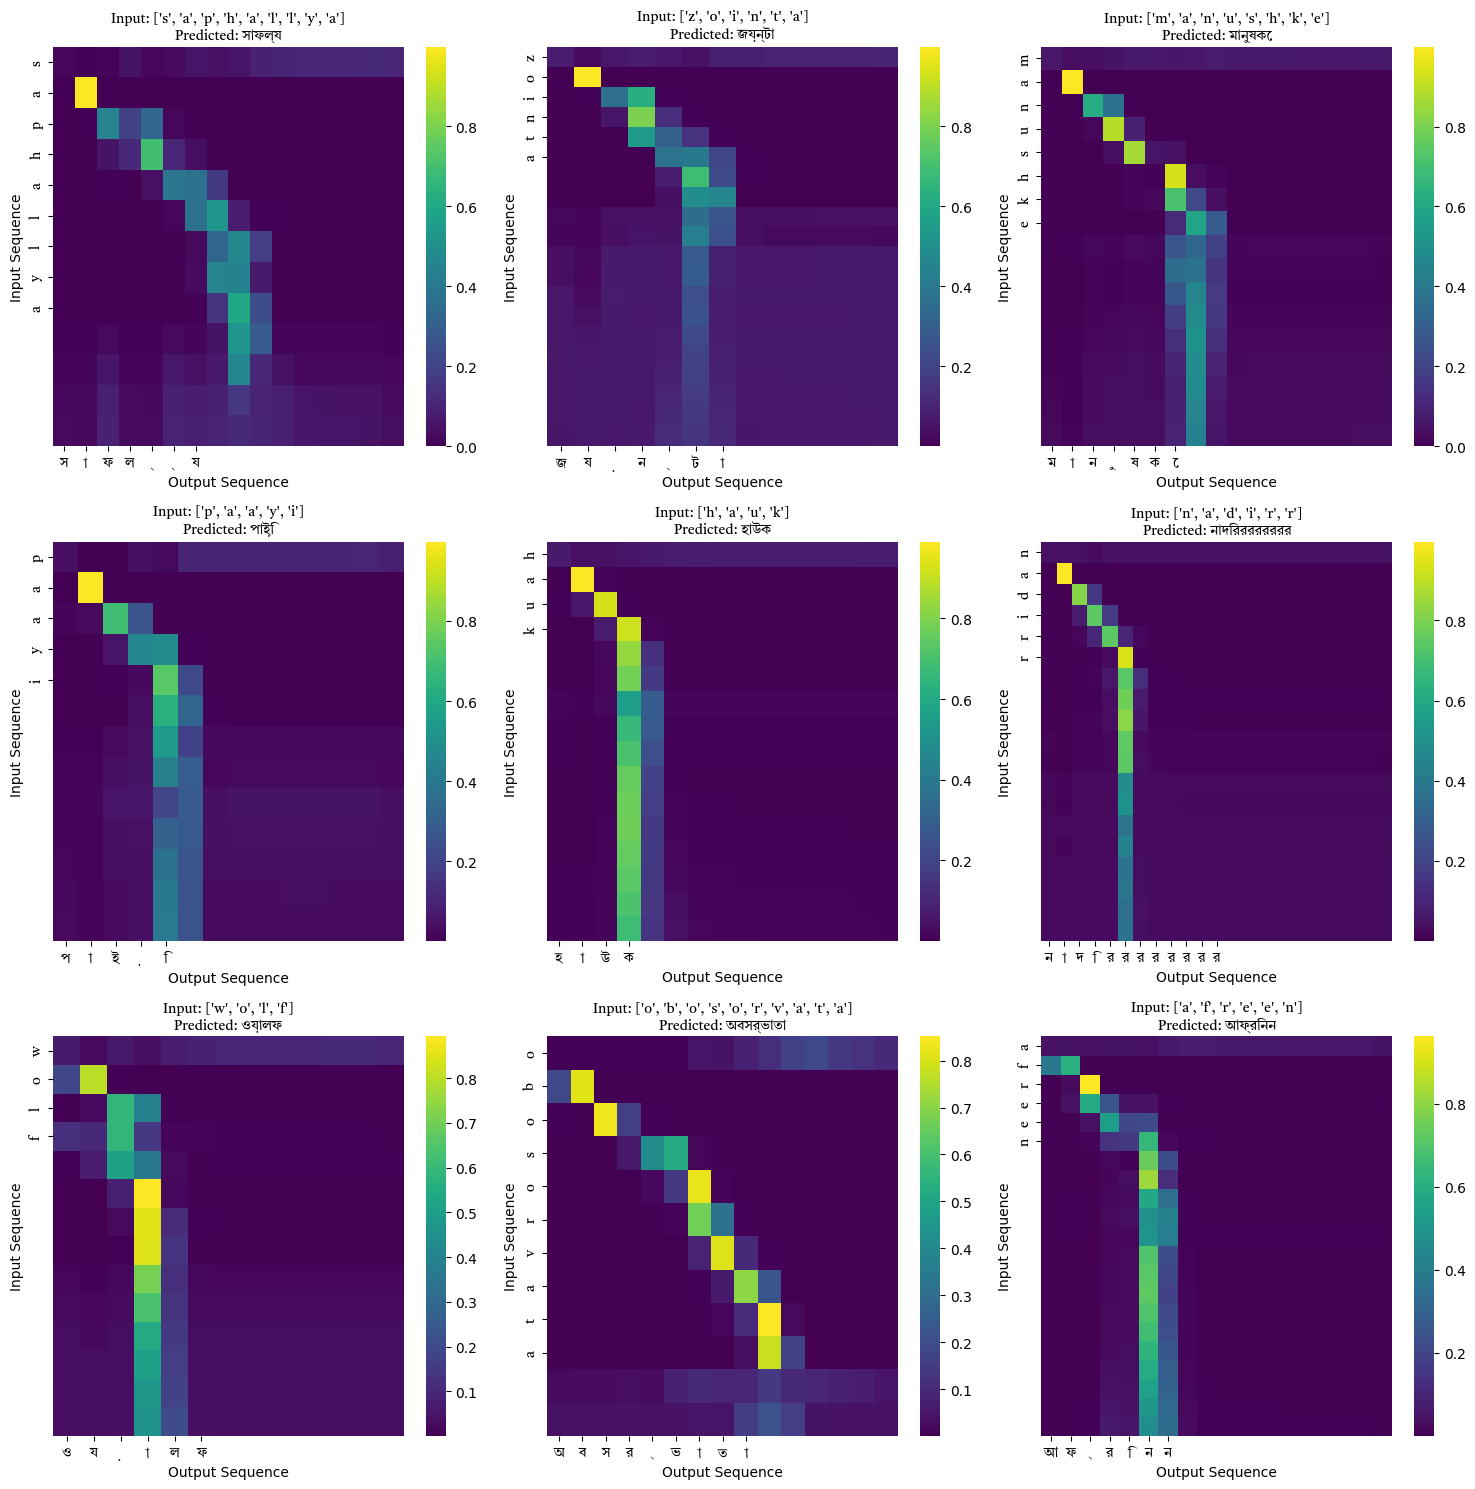

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# Function to decode indices into tokens, ignoring specified tokens
def decode_indices(indices, index_to_token, ignore_tokens):
    valid_indices = [index for index in indices if index not in ignore_tokens]  # Filter out the ignored tokens.
    return ''.join([index_to_token[index] for index in valid_indices if index in index_to_token])  # Convert indices to tokens and join them into a string.

# Function to plot attention weights using seaborn's heatmap
def plot_attention(ax, input_text, output_text, attention_weights, font_properties):
    attention_weights = attention_weights.squeeze(1)  # Remove singleton dimensions from attention weights.
    sns.heatmap(attention_weights, xticklabels=output_text, yticklabels=input_text, ax=ax, cmap='viridis')  # Plot the attention weights as a heatmap.
    ax.set_xticklabels(output_text, fontproperties=font_properties)  # Set Bengali font for x-axis labels
    ax.set_yticklabels(input_text, fontproperties=font_properties)  # Set Bengali font for y-axis labels
    ax.set_xlabel('Output Sequence')  # Set the x-axis label.
    ax.set_ylabel('Input Sequence')  # Set the y-axis label.
    title = f'Input: {input_text}\nPredicted: {predicted_text}'  # Combine input and predicted texts with a newline character
    ax.set_title(title, fontproperties=font_properties)  # Set the combined title

# Assume test_predictions are obtained from the predict function
test_predictions = predict(model, test_loader, device)  # Get predictions and attention weights from the model.

# Tokens to ignore during decoding
ignore_tokens = {
    bangla_token_to_index['<eos>'],  # Ignore the <eos> token.
    bangla_token_to_index['<pad>'],  # Ignore the <pad> token.
    bangla_token_to_index['<sos>']  # Ignore the <sos> token.
}

# Load the Bengali font
bengali_font_path = "/kaggle/input/tiro-beng/TiroBangla-Regular.ttf"  # Specify the path to a Bengali font file
bengali_font = fm.FontProperties(fname=bengali_font_path, size=10)  # Create a font property

# Plotting in a 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(15, 15))  # Create a 3x3 grid of subplots with specified figure size.
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration.

for idx, (source_indices, target_indices, output_indices, attention_weights) in enumerate(test_predictions[:9]):  # Iterate over the first 9 test predictions.
    input_text = decode_indices(source_indices[0], latin_index_to_token, ignore_tokens)  # Decode the source indices into input text.
    predicted_text = decode_indices(output_indices[0], bangla_index_to_token, ignore_tokens)  # Decode the output indices into predicted text.
    attention = attention_weights[0]  # Get the attention weights for the first sequence.
    
    plot_attention(axes[idx], list(input_text), list(predicted_text), attention, bengali_font)  # Plot the attention weights.

# Hide any remaining empty subplots
for j in range(idx + 1, len(axes)):  # Iterate over any remaining subplots.
    fig.delaxes(axes[j])  # Delete the empty subplot.

plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()  # Display the figure.


# **Wandb setup**

In [23]:
import wandb
import numpy as np
from types import SimpleNamespace
import random

# key = input('Enter your API:')
wandb.login(key='25c2257eaf6c22aa056893db14da4ee2bf0a531a')  #25c2257eaf6c22aa056893db14da4ee2bf0a531a

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# **For training and evaluating model on the training and validation dataset wandb setup**

In [56]:
sweep_config = {
    'method': 'bayes',
    'name' : 'sweep attn 4',
    'metric': {
        'name': 'Val_Accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'input_embed_size': {
            'values': [16,32,64,256,512]
        },
        'num_enc_layers':{
            'values': [1]
        },
        'num_dec_layers':{
            'values': [1]
        },
        'hid_layer_size': {
            'values': [16,32,64,256,512]
        },
        'cell_type': {
            'values': ['lstm']
        },
        'bidirectional':{
            'values': [True]
        },
        'dropout': {
            'values': [0.2, 0.3]
        },
        'epochs':{
            'values': [5,7,10,12]
        },
#       'beam search in decoder with different beam sizes': 
    }
}

sweep_id = wandb.sweep(sweep = sweep_config, project="Deep_Learning_A3_partB")


Create sweep with ID: xjh151he
Sweep URL: https://wandb.ai/parthasakhapaul/Deep_Learning_A3_partB/sweeps/xjh151he


In [ ]:
# import wandb

def main():
    # Initialize a new wandb run
    with wandb.init() as run:
        # Construct run name from configuration
        run_name = "-embed_size-"+str(wandb.config.input_embed_size)+"-layers_enc-"+str(wandb.config.num_enc_layers)+"-layers_dec-"+str(wandb.config.num_dec_layers)+"-hid_size-"+str(wandb.config.hid_layer_size)+"-cell_type-"+wandb.config.cell_type+"-bidirectional-"+str(wandb.config.bidirectional)+"-dropout-"+str(wandb.config.dropout)+"-epoch-"+str(wandb.config.epochs)
        wandb.run.name = run_name

        # Constants defining the dimensions of the input and output character sets
        INPUT_DIM = 100  # size of the Latin character set
        OUTPUT_DIM = 100  # size of the Bangla character set

        # Constants defining the dimensions of the embeddings for encoder and decoder
        ENC_EMB_DIM = wandb.config.input_embed_size  # Encoder embedding dimension
        DEC_EMB_DIM = wandb.config.input_embed_size  # Decoder embedding dimension

        # Constants defining the dimension of the hidden layers for encoder and decoder
        HID_DIM = wandb.config.hid_layer_size  # Hidden dimension size

        # Constants defining the number of layers for encoder and decoder
        ENC_LAYERS = wandb.config.num_enc_layers  # Number of layers in the encoder
        DEC_LAYERS = wandb.config.num_dec_layers  # Number of layers in the decoder
        

        # Constants defining the type of RNN cell to use for encoder and decoder
        ENC_RNN_CELL = wandb.config.cell_type  # RNN cell type for the encoder
        DEC_RNN_CELL = wandb.config.cell_type  # RNN cell type for the decoder
        
#         encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, ENC_LAYERS, ENC_RNN_CELL, dropout=0.3, bidirectional=True)
#         decoder = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, DEC_LAYERS, encoder.num_layers, attention, DEC_RNN_CELL, dropout=0.3, bidirectional = True)
        # Instantiate the encoder with specified configurations
        encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, ENC_LAYERS, ENC_RNN_CELL, dropout = wandb.config.dropout, bidirectional = wandb.config.bidirectional)
        attention = Attention(HID_DIM, ENC_RNN_CELL)
        # Instantiate the decoder with specified configurations
        decoder = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, DEC_LAYERS, encoder.num_layers, attention, DEC_RNN_CELL, dropout = wandb.config.dropout, bidirectional = wandb.config.bidirectional)

        # Determine the computing device (CUDA if available, otherwise CPU)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Print the device will be used
        print(f"Using device: {device}")

        # Instantiate the Seq_to_Seq model and move it to the chosen computing device
        model = Seq_to_Seq(encoder, decoder).to(device)
        print(model)
        
        
        # Setting the number of epochs the training process should run
        NUM_EPOCHS = wandb.config.epochs
        # Set the maximum norm of the gradients to 1 to prevent exploding gradients
        CLIP = 1
        # Initialize the optimizer, Adam
        optimizer = torch.optim.Adam(model.parameters())
        # Padding token index should be ignored in loss calculation
        ignore_index = bangla_token_to_index['<pad>']
        # Define the loss function with 'ignore_index' to avoid affecting loss calculation with padding tokens
        criterion = nn.CrossEntropyLoss(ignore_index=ignore_index).to(device)

        # Start the training process for the defined number of epochs
        for epoch in range(NUM_EPOCHS):
            # Doing training on the train dataset and return average loss and accuracy
            train_loss, train_accuracy, _ = train(model, train_loader, optimizer, criterion, CLIP, device, ignore_index)
            # Evaluating the model on the validation dataset and return average loss and accuracy
            val_loss, val_accuracy , _ = evaluate(model, valid_loader, criterion, device, ignore_index)

            # Print the loss and accuracy for each epoch
            print(f'Epoch: {epoch+1}')
            print(f'\tTrain_Loss: {train_loss:.3f}, Train_Accuracy: {train_accuracy*100:.2f}%')
            print(f'\tVal_Loss: {val_loss:.3f},  Val_Accuracy: {val_accuracy*100:.2f}%')
            wandb.log({"train_accuracy": train_accuracy * 100, "training_loss": train_loss})
            wandb.log({"Val_Accuracy": val_accuracy * 100, "Val_Loss": val_loss})


wandb.agent(sweep_id, function=main, count=1)
wandb.finish()

# **For training and testing model on the training and test dataset wandb setup**

In [49]:
# -embed_size-64-layers_enc-1-layers_dec-1-hid_size-512-cell_type-lstm-bidirectional-True-dropout-0.3-epoch-12
sweep_config = {
    'method': 'bayes',
    'name' : 'sweep attn test 2',
    'metric': {
        'name': 'Test_Accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'input_embed_size': {
            'values': [64]
        },
        'num_enc_layers':{
            'values': [1]
        },
        'num_dec_layers':{
            'values': [1]
        },
        'hid_layer_size': {
            'values': [1024]
        },
        'cell_type': {
            'values': ['lstm']
        },
        'bidirectional':{
            'values': [True]
        },
        'dropout': {
            'values': [0.2]
        },
#       'beam search in decoder with different beam sizes': 
    }
}

sweep_id = wandb.sweep(sweep = sweep_config, project="Deep_Learning_A3_partB")


Create sweep with ID: jy8jtgrl
Sweep URL: https://wandb.ai/parthasakhapaul/Deep_Learning_A3_partB/sweeps/jy8jtgrl


In [50]:
# import wandb

def main():
    # Initialize a new wandb run
    with wandb.init() as run:
        # Construct run name from configuration
        run_name = "-embed_size-"+str(wandb.config.input_embed_size)+"-layers_enc-"+str(wandb.config.num_enc_layers)+"-layers_dec-"+str(wandb.config.num_dec_layers)+"-hid_size-"+str(wandb.config.hid_layer_size)+"-cell_type-"+wandb.config.cell_type+"-bidirectional-"+str(wandb.config.bidirectional)+"-dropout-"+str(wandb.config.dropout)
        wandb.run.name = run_name

        # Constants defining the dimensions of the input and output character sets
        INPUT_DIM = 100  # size of the Latin character set
        OUTPUT_DIM = 100  # size of the Bangla character set

        # Constants defining the dimensions of the embeddings for encoder and decoder
        ENC_EMB_DIM = wandb.config.input_embed_size  # Encoder embedding dimension
        DEC_EMB_DIM = wandb.config.input_embed_size  # Decoder embedding dimension

        # Constants defining the dimension of the hidden layers for encoder and decoder
        HID_DIM = wandb.config.hid_layer_size  # Hidden dimension size

        # Constants defining the number of layers for encoder and decoder
        ENC_LAYERS = wandb.config.num_enc_layers  # Number of layers in the encoder
        DEC_LAYERS = wandb.config.num_dec_layers  # Number of layers in the decoder
        

        # Constants defining the type of RNN cell to use for encoder and decoder
        ENC_RNN_CELL = wandb.config.cell_type  # RNN cell type for the encoder
        DEC_RNN_CELL = wandb.config.cell_type  # RNN cell type for the decoder
        
#         encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, ENC_LAYERS, ENC_RNN_CELL, dropout=0.3, bidirectional=True)
#         decoder = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, DEC_LAYERS, encoder.num_layers, attention, DEC_RNN_CELL, dropout=0.3, bidirectional = True)
        # Instantiate the encoder with specified configurations
        encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, ENC_LAYERS, ENC_RNN_CELL, dropout = wandb.config.dropout, bidirectional = wandb.config.bidirectional)
        attention = Attention(HID_DIM, ENC_RNN_CELL)
        # Instantiate the decoder with specified configurations
        decoder = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, DEC_LAYERS, encoder.num_layers, attention, DEC_RNN_CELL, dropout = wandb.config.dropout, bidirectional = wandb.config.bidirectional)

        # Determine the computing device (CUDA if available, otherwise CPU)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Print the device will be used
        print(f"Using device: {device}")

        # Instantiate the Seq_to_Seq model and move it to the chosen computing device
        model = Seq_to_Seq(encoder, decoder).to(device)
        print(model)
        
        
        # Setting the number of epochs the training process should run
        NUM_EPOCHS = 30
        # Set the maximum norm of the gradients to 1 to prevent exploding gradients
        CLIP = 1
        # Initialize the optimizer, Adam
        optimizer = torch.optim.Adam(model.parameters())
        # Padding token index should be ignored in loss calculation
        ignore_index = bangla_token_to_index['<pad>']
        # Define the loss function with 'ignore_index' to avoid affecting loss calculation with padding tokens
        criterion = nn.CrossEntropyLoss(ignore_index=ignore_index).to(device)

        # Start the training process for the defined number of epochs
        for epoch in range(NUM_EPOCHS):
            # Doing training on the train dataset and return average loss and accuracy
            train_loss, train_accuracy, _ = train(model, train_loader, optimizer, criterion, CLIP, device, ignore_index)
            # Evaluating the model on the validation dataset and return average loss and accuracy
            val_loss, val_accuracy, _ = evaluate(model, test_loader, criterion, device, ignore_index)

            # Print the loss and accuracy for each epoch
            print(f'Epoch: {epoch+1}')
            print(f'\tTrain_Loss: {train_loss:.3f}, Train_Accuracy: {train_accuracy*100:.2f}%')
            print(f'\tTest_Loss: {val_loss:.3f},  Test_Accuracy: {val_accuracy*100:.2f}%')
            wandb.log({"train_accuracy": train_accuracy * 100, "training_loss": train_loss})
            wandb.log({"Test_Accuracy": val_accuracy * 100, "Test_Loss": val_loss})
            

wandb.agent(sweep_id, function=main, count=1)
wandb.finish()

wandb: Agent Starting Run: 4nof95rd with config:
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dropout: 0.2
wandb: 	hid_layer_size: 1024
wandb: 	input_embed_size: 64
wandb: 	num_dec_layers: 1
wandb: 	num_enc_layers: 1


Using device: cuda
Seq_to_Seq(
  (encoder): Encoder(
    (embedding): Embedding(100, 64)
    (dropout): Dropout(p=0.2, inplace=False)
    (rnn): LSTM(64, 512, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(100, 64)
    (dropout): Dropout(p=0.2, inplace=False)
    (attention): Attention(
      (attn): Linear(in_features=2048, out_features=1024, bias=True)
    )
    (rnn): LSTM(1088, 1024, batch_first=True)
    (fc): Linear(in_features=1024, out_features=100, bias=True)
  )
)
Epoch: 1
	Train_Loss: 1.396, Train_Accuracy: 8.53%
	Test_Loss: 1.466,  Test_Accuracy: 13.77%
Epoch: 2
	Train_Loss: 0.680, Train_Accuracy: 16.91%
	Test_Loss: 1.379,  Test_Accuracy: 17.24%
Epoch: 3
	Train_Loss: 0.521, Train_Accuracy: 22.30%
	Test_Loss: 1.361,  Test_Accuracy: 17.90%
Epoch: 4
	Train_Loss: 0.439, Train_Accuracy: 25.99%
	Test_Loss: 1.295,  Test_Accuracy: 25.98%
Epoch: 5
	Train_Loss: 0.379, Train_Accuracy: 28.49%
	Test_Loss: 1.340,  Test_Accuracy: 20.83%
Epoch: 6

Test_Accuracy,▁▂▃▆▄▆▆▅▆▅▆▆▇▅█▇▆▆▇▅▅▅▅▆▆▇█▇█▆
Test_Loss,▂▂▂▁▁▁▂▂▂▃▃▃▄▅▄▅▆▅▅▇▇▇▇▇▇▇████
train_accuracy,▁▂▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▆▇▇▇▇▇███
training_loss,█▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Test_Accuracy,25.80566
Test_Loss,2.08247
train_accuracy,65.73438
training_loss,0.06872
